# Riichi Analysis

The purpose of this notebook is to do analysis on when people tend to riichi. Data was extracted using main.py, and it contains every game hanchan yonma played in the tenhou phoenix room from 2009 to 2021. There are 1.4 million entries in our dataset, which contains the columns `num_discards` to represent how many discards they've done, `tile` to represent the tile they called riichi on, and `winning_tiles` which repesents their winning tiles. The tiles are integers 0-34 corresponding to man pin sou winds dragons.

The main questions that I'm looking to answer are:
- What's the average turn someone riichi's at?
- Are tiles around the tile someone riichis dangerous (if it's kks tile vs not)?

## Imports

In [2]:
# Imports
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy as np


In [3]:
# Data Frame

with sqlite3.connect(os.path.abspath(os.path.abspath('') + "/../db/rii.db")) as conn:
    df = pd.read_sql("SELECT * FROM riichi", conn)

df["wt"] = df["winning_tiles"].map(json.loads)
df = df.drop(columns=["winning_tiles"])
df = df.rename(columns={"wt": "winning_tiles"})

## Exploratory Data Analysis

In [4]:
df.head()

,log_id,num_discards,tile,winning_tiles
0,1,13,21,[16]
1,1,7,7,[32]
2,1,10,17,"[13, 33]"
3,1,8,2,"[10, 13, 16]"
4,1,11,22,"[0, 3]"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403034 entries, 0 to 1403033
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   log_id         1403034 non-null  int64 
 1   num_discards   1403034 non-null  int64 
 2   tile           1403034 non-null  int64 
 3   winning_tiles  1403034 non-null  object
dtypes: int64(3), object(1)
memory usage: 42.8+ MB


In [6]:
df.describe()

,log_id,num_discards,tile
count,1.403034e+06,1.403034e+06,1.403034e+06
mean,9.376356e+04,8.822359e+00,1.487935e+01
std,5.418760e+04,3.091507e+00,9.091556e+00
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.665200e+04,7.000000e+00,7.000000e+00
50%,9.381800e+04,9.000000e+00,1.500000e+01
75%,1.408400e+05,1.100000e+01,2.200000e+01
max,1.873270e+05,1.900000e+01,3.300000e+01


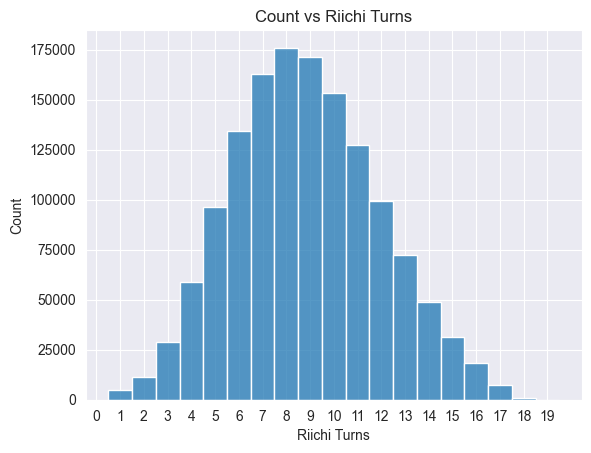

In [7]:
bins = [i for i in range(20)]

sns.histplot(df["num_discards"], bins=bins, discrete=True)
plt.xlabel("Riichi Turns")
plt.ylabel("Count")
plt.title("Count vs Riichi Turns")
plt.xticks(bins)
plt.show()

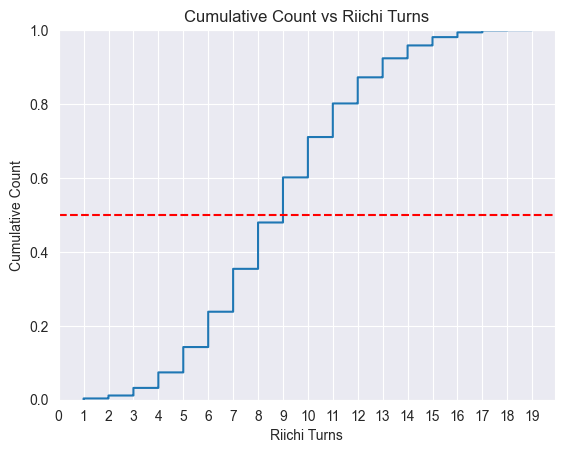

In [8]:
bins = [i for i in range(20)]
sns.ecdfplot(data=df["num_discards"], stat="proportion")
plt.xlabel("Riichi Turns")
plt.ylabel("Cumulative Count")
plt.title("Cumulative Count vs Riichi Turns")
plt.xticks(bins)
plt.axhline(0.5, color='red', linestyle='--')

plt.show()

## Proximate Tile Deal In Rate

In [9]:
def are_tiles_close(tile1, tile2, dist=2):
    suit1 = tile1 // 9
    suit2 = tile2 // 9

    return suit1 == suit2 and suit1 != 3 and abs(tile1 - tile2) <= dist

df['has_close_tile'] = df.apply(lambda row: any(map(lambda x: are_tiles_close(row["tile"], x), row["winning_tiles"])), axis=1)

In [10]:
def is_kks_tile(tile):
    suit = tile // 9
    num = tile % 9
    
    return suit == 3 or num == 0 or num == 8

df['rii_tile_safe'] = df['tile'].map(is_kks_tile)

In [20]:
df_non_honor = df.loc[df['tile'] < 27]

prop_all_incl = df['has_close_tile'].sum() / df.shape[0]
prop_all = df_non_honor['has_close_tile'].sum() / df_non_honor.shape[0]
prop_nonsafe = ((df_non_honor['has_close_tile']) & (~df_non_honor['rii_tile_safe'])).sum() / (~df_non_honor['rii_tile_safe']).sum()
prop_safe = (df_non_honor['has_close_tile'] & df_non_honor['rii_tile_safe']).sum() / df_non_honor['rii_tile_safe'].sum()

print(f"Percentage All: {round(prop_all * 100, 2)}%")
print(f"Percentage Nonsafe: {round(prop_nonsafe * 100, 2)}%")
print(f"Percentage Safe: {round(prop_safe * 100, 2)}%")
print(f"Percentage All (incl honors): {round(prop_all_incl * 100, 2)}%")

Percentage All: 20.11%
Percentage Nonsafe: 20.91%
Percentage Safe: 16.2%
Percentage All (incl honors): 17.84%


In general, if the discard tile is non honor, there seems to be around a **20.11%** chance that a tile close to the riichi tile will deal in. If the tile is 2-8, then there's around a **20.91%** chance that a tile close to the riichi tile will deal in, and if the tile is 1 or 9, then there's around a **16.2%** chance that a tile close to it will deal in. 

Overall, if we include honors, then there's a **17.84%** chance a tile close to the discarded tile will deal in.

In [28]:
STARTING_SEED = 1

def simulate(waits, non_honor=True):
    tile = np.random.randint(0, 34 - 7 * non_honor)
    return any(map(lambda x: are_tiles_close(tile, x), waits))

np.random.seed(STARTING_SEED)

iterations = 1_000_000

samples = df.sample(n=iterations, replace=True, random_state=STARTING_SEED)
samples['close'] = df['winning_tiles'].map(simulate)

prop = samples['close'].sum() / iterations
print(f"Percentage: {prop * 100:.2f}%")

Percentage: 23.49%


Assuming we discard a random tile, there is around a **23.49%** chance that a tile close to the riichi tile will deal in. 